### Librerías

In [1]:
import numpy as np
import pandas as pd
from plotnine import *
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
from sklearn.model_selection import train_test_split
from datetime import timedelta
import statsmodels.api as sm
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn import metrics as mt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve

### Carga de datos desde GitHub

In [2]:
url = 'https://raw.githubusercontent.com/DavidValGon/DS_LATAM/main/dataset_SCL.csv'
df = pd.read_csv(url, sep = ";")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68206 entries, 0 to 68205
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Fecha-I    68206 non-null  object
 1   Vlo-I      68206 non-null  object
 2   Ori-I      68206 non-null  object
 3   Des-I      68206 non-null  object
 4   Emp-I      68206 non-null  object
 5   Fecha-O    68206 non-null  object
 6   Vlo-O      68205 non-null  object
 7   Ori-O      68206 non-null  object
 8   Des-O      68206 non-null  object
 9   Emp-O      68206 non-null  object
 10  DIA        68206 non-null  int64 
 11  MES        68206 non-null  int64 
 12  AÑO        68206 non-null  int64 
 13  DIANOM     68206 non-null  object
 14  TIPOVUELO  68206 non-null  object
 15  OPERA      68206 non-null  object
 16  SIGLAORI   68206 non-null  object
 17  SIGLADES   68206 non-null  object
dtypes: int64(3), object(15)
memory usage: 9.4+ MB


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (1,6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


### Observación: no hay valores nulos

## Variables

Creación de variables cambios de variables para preparar un data set a ingresar en el modelo elegido

In [3]:
df["Fecha-I-DMA"]=pd.to_datetime(df["Fecha-I"], format ="%d/%m/%Y %H:%M") #Formato fecha
df["Fecha-O"]=pd.to_datetime(df["Fecha-O"], format ="%d/%m/%Y %H:%M") #Formato fecha
df["Fecha-I"]=pd.to_datetime(df["Fecha-I"], format ="%d/%m/%Y %H:%M") #Formato fecha
df["Fecha-I-DMA"]=df["Fecha-I-DMA"].dt.strftime('%d/%m/%Y')  #Formato fecha
df["Fecha-temp"]=df['Fecha-I'].dt.month*100+df['Fecha-I'].dt.day #Variable mes + día
df['hora_min'] = df['Fecha-I'].dt.hour*100+df['Fecha-I'].dt.minute #Variable hora + minuto

In [4]:
df["dif"]= df["Fecha-O"] - df["Fecha-I"] #Variable diferencia entre fecha de operación y fecha programada en días
df["dif_min"]= df["dif"] / np.timedelta64(1, 'm')  #Variable diferencia entre fecha de operación y fecha programada en minutos
df['atraso_15'] = np.where(df['dif_min']>15, 1, 0) #Variable dummie para retrasos mayores a 15 minutos
df['atraso_1'] = np.where(df['dif_min']>0, 1, 0) #Variable dummie para retrasos mayores a 1 minutos
df['hora'] = df['Fecha-I'].dt.hour #Variable auxiliar: hora programada de salida
df['temporada_alta'] = df['Fecha-temp'].apply(lambda x: 1 if x >= 1215 else (1 if x <= 303 else (1 if (x >= 715 and x <= 731) else (1 if (x >= 911 and x <= 930) else 0)))) #Variable dummie para temporada
df['periodo_dia'] = df['hora'].apply(lambda x: "mañana" if (x >= 5 and x <= 11) else ("tarde" if (x >= 12 and x <= 18) else "noche")) #Variable para hora del día
df['Vlo-I'] = df['Vlo-I'].astype(str) #Ajuste de variable para ingresarla al modelo
df['Vlo-I'] = df['Vlo-I'].str.replace(r'\D+', "0")
df['Vlo-I'] = df['Vlo-I'].astype(int)
df['Vlo-O'] = df['Vlo-O'].astype(str) #Ajuste de variable para ingresarla al modelo
df['Vlo-O'] = df['Vlo-O'].str.replace(r'\D+', "0")
df['Vlo-O'] = df['Vlo-O'].astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  if sys.path[0] == '':


## 2. Genera las columnas adicionales y luego expórtelas en un archivo synthetic_features.csv :

In [5]:
df_sint = df.loc[:, ['temporada_alta','dif_min','atraso_15','atraso_15']]
df_sint.to_csv('synthetic_features.csv')

In [6]:
# Se eliminan variables que están contenidas en otras (como fechas y programadas de vuelo)
# o variables que no estarán en un ambiente operación (fecha de operación de vuelos)
df = df.drop(["Fecha-I","Ori-I","Des-I","Emp-I","Fecha-O","Ori-O","Des-O","Emp-O", "Fecha-I-DMA","SIGLAORI","AÑO", "dif", "hora"], axis = 1)

In [7]:
print(df.head(5))

   Vlo-I  Vlo-O  DIA  MES     DIANOM TIPOVUELO              OPERA SIGLADES  \
0    226    226    1    1    Domingo         I  American Airlines    Miami   
1    226    226    2    1      Lunes         I  American Airlines    Miami   
2    226    226    3    1     Martes         I  American Airlines    Miami   
3    226    226    4    1  Miercoles         I  American Airlines    Miami   
4    226    226    5    1     Jueves         I  American Airlines    Miami   

   Fecha-temp  hora_min  dif_min  atraso_15  atraso_1  temporada_alta  \
0         101      2330      3.0          0         1               1   
1         102      2330      9.0          0         1               1   
2         103      2330      9.0          0         1               1   
3         104      2330      3.0          0         1               1   
4         105      2330     -2.0          0         0               1   

  periodo_dia  
0       noche  
1       noche  
2       noche  
3       noche  
4       noch

In [8]:
#Creación de variables numéricas codificadas a partir de variables no numéricas

df['DIANOM_ENCOD'] = df['DIANOM'].map( {"Lunes" : 1,
"Martes" : 2,
"Miercoles" : 3,
"Jueves" : 4,
"Viernes" : 5,
"Sabado" : 6,
"Domingo" : 7} ).astype(int)

df['TIPOVUELO_ENCOD'] = df['TIPOVUELO'].map( {"N" : 0,
"I" : 1} ).astype(int)

df['OPERA_ENCOD'] = df['OPERA'].map( {"American Airlines" : 1,
"Air Canada" : 2,
"Air France" : 3,
"Aeromexico" : 4,
"Aerolineas Argentinas" : 5,
"Austral" : 6,
"Avianca" : 7,
"Alitalia" : 8,
"British Airways" : 9,
"Copa Air" : 10,
"Delta Air" : 11,
"Gol Trans" : 12,
"Iberia" : 13,
"K.L.M." : 14,
"Qantas Airways" : 15,
"United Airlines" : 16,
"Grupo LATAM" : 17,
"Sky Airline" : 18,
"Latin American Wings" : 19,
"Plus Ultra Lineas Aereas" : 20,
"JetSmart SPA" : 21,
"Oceanair Linhas Aereas" : 22,
"Lacsa" : 23} ).astype(int)

df['SIGLADES_ENCOD'] = df['SIGLADES'].map( {"Miami" : 1,
"Dallas" : 2,
"Buenos Aires" : 3,
"Toronto" : 4,
"Paris" : 5,
"Ciudad de Mexico" : 6,
"Bogota" : 7,
"Roma" : 8,
"Londres" : 9,
"Ciudad de Panama" : 10,
"Atlanta" : 11,
"Sao Paulo" : 12,
"Rio de Janeiro" : 13,
"Florianapolis" : 14,
"Madrid" : 15,
"Lima" : 16,
"Sydney" : 17,
"Houston" : 18,
"Asuncion" : 19,
"Cataratas Iguacu" : 20,
"Puerto Montt" : 21,
"Punta Arenas" : 22,
"Puerto Natales" : 23,
"Balmaceda" : 24,
"Temuco" : 25,
"Valdivia" : 26,
"Concepcion" : 27,
"La Serena" : 28,
"Copiapo" : 29,
"Calama" : 30,
"Antofagasta" : 31,
"Iquique" : 32,
"Arica" : 33,
"Mendoza" : 34,
"Cordoba" : 35,
"Montevideo" : 36,
"Castro (Chiloe)" : 37,
"Osorno" : 38,
"Orlando" : 39,
"Nueva York" : 40,
"Guayaquil" : 41,
"Cancun" : 42,
"Punta Cana" : 43,
"Los Angeles" : 44,
"Auckland N.Z." : 45,
"Isla de Pascua" : 46,
"La Paz" : 47,
"Santa Cruz" : 48,
"Curitiba, Bra." : 49,
"Quito" : 50,
"Bariloche" : 51,
"Rosario" : 52,
"Washington" : 53,
"Tucuman" : 54,
"Melbourne" : 55,
"San Juan, Arg." : 56,
"Neuquen" : 57,
"Pisco, Peru" : 58,
"Ushuia" : 59,
"Puerto Stanley" : 60,
"Punta del Este" : 61,
"Cochabamba" : 62} ).astype(int)

df['periodo_dia_ENCOD'] = df['periodo_dia'].map( {"mañana" : 1,
"tarde" : 2,
"noche" : 3} ).astype(int)

In [9]:
print(df.head(5))

   Vlo-I  Vlo-O  DIA  MES     DIANOM TIPOVUELO              OPERA SIGLADES  \
0    226    226    1    1    Domingo         I  American Airlines    Miami   
1    226    226    2    1      Lunes         I  American Airlines    Miami   
2    226    226    3    1     Martes         I  American Airlines    Miami   
3    226    226    4    1  Miercoles         I  American Airlines    Miami   
4    226    226    5    1     Jueves         I  American Airlines    Miami   

   Fecha-temp  hora_min  dif_min  atraso_15  atraso_1  temporada_alta  \
0         101      2330      3.0          0         1               1   
1         102      2330      9.0          0         1               1   
2         103      2330      9.0          0         1               1   
3         104      2330      3.0          0         1               1   
4         105      2330     -2.0          0         0               1   

  periodo_dia  DIANOM_ENCOD  TIPOVUELO_ENCOD  OPERA_ENCOD  SIGLADES_ENCOD  \
0       noche  

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68206 entries, 0 to 68205
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Vlo-I              68206 non-null  int64  
 1   Vlo-O              68206 non-null  int64  
 2   DIA                68206 non-null  int64  
 3   MES                68206 non-null  int64  
 4   DIANOM             68206 non-null  object 
 5   TIPOVUELO          68206 non-null  object 
 6   OPERA              68206 non-null  object 
 7   SIGLADES           68206 non-null  object 
 8   Fecha-temp         68206 non-null  int64  
 9   hora_min           68206 non-null  int64  
 10  dif_min            68206 non-null  float64
 11  atraso_15          68206 non-null  int64  
 12  atraso_1           68206 non-null  int64  
 13  temporada_alta     68206 non-null  int64  
 14  periodo_dia        68206 non-null  object 
 15  DIANOM_ENCOD       68206 non-null  int64  
 16  TIPOVUELO_ENCOD    682

In [11]:
Mayor_1 = sum(df.atraso_1)/len(df)
Mayor_15 = sum(df.atraso_15)/len(df)
print(Mayor_1)
print(Mayor_15)

0.6671993666246371
0.18493974137172683


* Si consideremos como atraso de, al menos, **1 minuto** entre la hora de prgramación de vuelo y la hora real de salida, la posibilidad de que un vuelo se atrase es de un 66,7%
* Si consideremos como atraso de, al menos, **15 minuto** entre la hora de prgramación de vuelo y la hora real de salida, la posibilidad de que un vuelo se atrase es de un 18,5%

## 1. ¿Cómo se distribuyen los datos? ¿Qué te llama a atención o cuál es tu conclusión sobre esto?

A partir del histograma y la distribución por quintiles, es posible ver que la distribución tiene una gran agrupación de valores en torno a 0 y muy pocos valores altos. En función al análisis solicitado, es posible considerar como 0 toda diferencia negativa entre la hora programada y la hora de salida, es decir; si el vuelo sale antes de la hora programada, tiene un retraso de 0 minutos. A partir de lo anterior, es posible considerar el comportamiento de la distribución de los atrasos en los vuelos como una distribuición de Poisson o un Log Normal.

In [12]:
df["dif_min"].describe()

count    68206.000000
mean         9.110855
std         19.313387
min        -14.000000
25%         -1.000000
50%          4.000000
75%         12.000000
max        161.000000
Name: dif_min, dtype: float64

(array([  770.,  1398.,  5342., 10400., 15701.,  8143.,  7734.,  3936.,
         3819.,  1877.,  1829.,  1045.,  1014.,   608.,   647.,   415.,
          434.,   267.,   318.,   197.,   261.,   160.,   209.,   118.,
          133.,   116.,   117.,    91.,   112.,    79.,    76.,    67.,
           85.,    46.,    77.,    52.,    52.,    47.,    68.,    35.,
           43.,    32.,    43.,    17.,    33.,    18.,    30.,    30.,
           27.,    38.]),
 array([-14. , -10.5,  -7. ,  -3.5,   0. ,   3.5,   7. ,  10.5,  14. ,
         17.5,  21. ,  24.5,  28. ,  31.5,  35. ,  38.5,  42. ,  45.5,
         49. ,  52.5,  56. ,  59.5,  63. ,  66.5,  70. ,  73.5,  77. ,
         80.5,  84. ,  87.5,  91. ,  94.5,  98. , 101.5, 105. , 108.5,
        112. , 115.5, 119. , 122.5, 126. , 129.5, 133. , 136.5, 140. ,
        143.5, 147. , 150.5, 154. , 157.5, 161. ]),
 <a list of 50 Patch objects>)

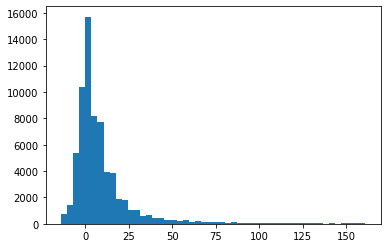

In [13]:
plt.hist(df["dif_min"], bins=50)

## 3. ¿Cómo se compone la tasa de atraso por destino, aerolínea, mes del año, día de la semana, temporada, tipo de vuelo? ¿Qué variables esperarías que más influyeran en predecir atrasos?

Tasa de atraso mayor a 15 minutos por destino

In [14]:
df_atraso_15_aero = df.groupby("SIGLADES")[["atraso_15"]].mean()
df_atraso_15_aero.head(10)

,atraso_15
SIGLADES,
Antofagasta,0.146388
Arica,0.135468
Asuncion,0.284483
Atlanta,0.058659
Auckland N.Z.,0.373961
Balmaceda,0.146603
Bariloche,0.500000
Bogota,0.258728
Buenos Aires,0.255722


Tasa de atraso mayor a 15 minutos por destino

In [15]:
df_atraso_1_aero = df.groupby("SIGLADES")[["atraso_1"]].mean()
df_atraso_1_aero.head(10)

,atraso_1
SIGLADES,
Antofagasta,0.607847
Arica,0.639984
Asuncion,0.814655
Atlanta,0.307263
Auckland N.Z.,0.850416
Balmaceda,0.748510
Bariloche,1.000000
Bogota,0.652120
Buenos Aires,0.719021


Tasa de atraso mayor a 1 minuto por aerolínea

In [16]:
df_atraso_1_linea = df.groupby("OPERA")[["atraso_1"]].mean()
df_atraso_1_linea.head(10)

,atraso_1
OPERA,
Aerolineas Argentinas,0.591072
Aeromexico,0.222222
Air Canada,0.775221
Air France,0.421788
Alitalia,0.579151
American Airlines,0.284016
Austral,0.648649
Avianca,0.572917
British Airways,0.604878


Tasa de atraso mayor a 15 minutos por aerolínea

In [17]:
df_atraso_15_linea = df.groupby("OPERA")[["atraso_15"]].mean()
df_atraso_15_linea.head(10)

,atraso_15
OPERA,
Aerolineas Argentinas,0.240123
Aeromexico,0.028490
Air Canada,0.456637
Air France,0.083799
Alitalia,0.111969
American Airlines,0.067371
Austral,0.202703
Avianca,0.265625
British Airways,0.141463


Tasa de atraso mayor a 1 minuto según mes

In [18]:
df_atraso_1_mes = df.groupby("MES")[["atraso_1"]].mean()
df_atraso_1_mes.head(12)

,atraso_1
MES,
1,0.661755
2,0.652401
3,0.565669
4,0.592430
5,0.641221
6,0.648464
7,0.770027
8,0.647110
9,0.645455


Tasa de atraso mayor a 15 minutos según mes

In [19]:
df_atraso_15_mes = df.groupby("MES")[["atraso_15"]].mean()
df_atraso_15_mes.head(12)

,atraso_15
MES,
1,0.160118
2,0.151591
3,0.115104
4,0.116534
5,0.157824
6,0.171050
7,0.293391
8,0.173398
9,0.172371


Tasa de atraso mayor a 1 minuto según día de la semana

In [20]:
df_atraso_1_dia = df.groupby("DIANOM")[["atraso_1"]].mean()
df_atraso_1_dia.head(12)

,atraso_1
DIANOM,
Domingo,0.639241
Jueves,0.683543
Lunes,0.675155
Martes,0.642310
Miercoles,0.659947
Sabado,0.645953
Viernes,0.717159


Tasa de atraso mayor a 15 minutos según día de la semana

In [21]:
df_atraso_15_dia = df.groupby("DIANOM")[["atraso_15"]].mean()
df_atraso_15_dia.head(7)

,atraso_15
DIANOM,
Domingo,0.161086
Jueves,0.199493
Lunes,0.202152
Martes,0.169116
Miercoles,0.170850
Sabado,0.163194
Viernes,0.222017


Tasa de atraso mayor a 1 minuto según temporada (alta o baja)

In [22]:
df_atraso_1_tem = df.groupby("temporada_alta")[["atraso_1"]].mean()
df_atraso_1_tem.head(2)

,atraso_1
temporada_alta,
0,0.659031
1,0.683508


Tasa de atraso mayor a 15 minutos según temporada (alta o baja)

In [23]:
df_atraso_15_tem = df.groupby("temporada_alta")[["atraso_15"]].mean()
df_atraso_15_tem.head(2)

,atraso_15
temporada_alta,
0,0.17921
1,0.19638


Tasa de atraso mayor a 1 minuto según tipo de vuelo

In [24]:
df_atraso_1_vuelo = df.groupby("TIPOVUELO")[["atraso_1"]].mean()
df_atraso_1_vuelo.head(2)

,atraso_1
TIPOVUELO,
I,0.678521
N,0.657631


Tasa de atraso mayor a 15 minutos según tipo de vuelo

In [25]:
df_atraso_15_vuelo = df.groupby("TIPOVUELO")[["atraso_15"]].mean()
df_atraso_15_vuelo.head(2)

,atraso_15
TIPOVUELO,
I,0.225608
N,0.150571


In [26]:
# Se recortan las columnas que no entraran al modelo
df = df.drop(["DIANOM", "TIPOVUELO", "OPERA", "SIGLADES", "periodo_dia", "dif_min", "atraso_1"], axis = 1)

print(df.head(5))

   Vlo-I  Vlo-O  DIA  MES  Fecha-temp  hora_min  atraso_15  temporada_alta  \
0    226    226    1    1         101      2330          0               1   
1    226    226    2    1         102      2330          0               1   
2    226    226    3    1         103      2330          0               1   
3    226    226    4    1         104      2330          0               1   
4    226    226    5    1         105      2330          0               1   

   DIANOM_ENCOD  TIPOVUELO_ENCOD  OPERA_ENCOD  SIGLADES_ENCOD  \
0             7                1            1               1   
1             1                1            1               1   
2             2                1            1               1   
3             3                1            1               1   
4             4                1            1               1   

   periodo_dia_ENCOD  
0                  3  
1                  3  
2                  3  
3                  3  
4                  3  


## 4. Entrena uno o varios modelos (usando el/los algoritmo(s) que prefieras) para estimar la probabilidad de atraso de un vuelo. Siéntete libre de generar variables adicionales y/o complementar con variables externas.


### Árbol de decisión 


El árbol de decisión es un modelo que permite visualizar los caminos que recorre el algorítmo para el estado final de la predicción. Lo anterior, permite ver cuáles son las variables que mayor peso tienen en el modelo.

En primer lugar se realiza un K-Fold Cross Validation para obtener una visión general de cómo se comparta el árbol, además no se especifica profundidad ni cantidad de hojas. Crece libremente.

In [28]:
datos = df

In [29]:
inicio = datetime.now()

numFolds=20

X = datos
X = X.drop(['atraso_15'], axis=1)

#Crear objeto k-fold cross validation
kf = KFold(n_splits=numFolds, shuffle=True)
temp=kf.split(X)

allF1Test=np.zeros((numFolds,1))
allF1Train=np.zeros((numFolds,1))
allAcc=np.zeros((numFolds,1))
allRecall=np.zeros((numFolds,1))
allPrecision=np.zeros((numFolds,1))

index=0
for train_index, test_index in temp:
    
    #Crear Arbol
    arbolModel = DecisionTreeClassifier()
    
    varIndependienteE = X.iloc[train_index,:]#Extraer datos variables independientes
    varObjetivoE = datos.iloc[train_index,6]#Extraer dato variables dependientes  

    #Entrenar modelo
    arbolModel = arbolModel.fit(varIndependienteE,varObjetivoE)   
    prediccionE = arbolModel.predict(varIndependienteE)    
    allF1Train[index]=f1_score(varObjetivoE,prediccionE,pos_label=False)

    #Predecir
    varIndependienteT = X.iloc[test_index,:]
    varObjetivoT = datos.iloc[test_index,6]
    prediccionT = arbolModel.predict(varIndependienteT)
    
    allF1Test[index]=f1_score(varObjetivoT,prediccionT,pos_label=False)
    allRecall[index]=recall_score(varObjetivoT,prediccionT,pos_label=False)
    allPrecision[index]=precision_score(varObjetivoT,prediccionT,pos_label=False)
    allAcc[index]=accuracy_score(varObjetivoT,prediccionT)
    index+=1

#Imprima los resultados
print("Average F1-score train: ",allF1Train.mean(),"+-",allF1Train.std())
print("Average F1-score test: ",allF1Test.mean(),"+-",allF1Test.std())
print("Average recall test: ",allRecall.mean(),"+-",allRecall.std())
print("Average precision test: ",allPrecision.mean(),"+-",allPrecision.std())
print("Average accuracy test: ",allAcc.mean(),"+-",allAcc.std())
print("Profundidad: ",arbolModel.get_depth())
print("Número de hojas: ",arbolModel.get_n_leaves())

termino = datetime.now()
print("Duración: ", (termino - inicio))

Average F1-score train:  0.9999914792616137 +- 2.840248524403569e-06
Average F1-score test:  0.8429144125562618 +- 0.004338160516723896
Average recall test:  0.8357676311509119 +- 0.005548698792741663
Average precision test:  0.8502199574381233 +- 0.006023287968333014
Average accuracy test:  0.7461370492739119 +- 0.00608943861711155
Profundidad:  38
Número de hojas:  15638
Duración:  0:00:17.161755


Los resultados de este primer KF Cross Validation muestran un modelo con 43 niveles de profundidad, un F1-Score igual a 0,99 y un 74% de accuracy. 

En función de los resultados anteriores es necesario generar un nuevo KFold Cross Validation sobre los datos originales con una profundidad máxima sugerida, con la finalidad de generar una tabla resumen donde se muestren indicadores para cada nivel del árbol. Indicadores tales como: Media y Desviación estándar de entrenamiento y test además de Recall, Precision y Accuracy y los valores de la matriz de confusión. Con esta tabla será posible definir con fundamentos el mejor nivel de profundidad del árbol que optimice los resultados y los costos computacionales.

In [30]:
inicio = datetime.now()

#Defina el número de folds y la máxima profundida del árbol
numFolds=20
maximaProfundidad=42

resultados=pd.DataFrame(np.zeros((maximaProfundidad,15)),columns=["meanTrain",'stdTrain',"meanTest",'stdTest','meanRecallTest',"stdRecallTest",'meanPrecisionTest',"stdPrecisionTest",'meanAccTest',"stdAccTest","maxDepth","TP","FP","FN","TN"])

#Cree un objeto de k-fold cross validation con numFolds y shuffle=True
X = datos
X = X.drop(['atraso_15'], axis=1)

#Crear objeto k-fold cross validation
kf = KFold(n_splits=numFolds, shuffle=True)


for k in range(maximaProfundidad):    
    
    arbolModel = DecisionTreeClassifier(max_depth=k+1)
    
    allF1Test=np.zeros((numFolds,1))
    allF1Train=np.zeros((numFolds,1))
    allAcc=np.zeros((numFolds,1))
    allRecall=np.zeros((numFolds,1))
    allPrecision=np.zeros((numFolds,1))
    allTP=np.zeros((numFolds,1))
    allFP=np.zeros((numFolds,1))
    allFN=np.zeros((numFolds,1))
    allTN=np.zeros((numFolds,1))
    
    index=0
    #Cree un ciclo for para aplicar K-fold cross validation en originalData
    for train_index, test_index in kf.split(X):        
        
        varIndependienteE = X.iloc[train_index,:]#Extraer datos variables independientes
        varObjetivoE = datos.iloc[train_index,6]#Extraer dato variables dependientes  

        #Entrenar modelo
        arbolModel = arbolModel.fit(varIndependienteE,varObjetivoE)   
        prediccionE = arbolModel.predict(varIndependienteE)    
        allF1Train[index]=f1_score(varObjetivoE,prediccionE,pos_label=False)

        #Predecir
        varIndependienteT = X.iloc[test_index,:]
        varObjetivoT = datos.iloc[test_index,6]
        prediccionT = arbolModel.predict(varIndependienteT)

        allF1Test[index]=f1_score(varObjetivoT,prediccionT,pos_label=False)
        allRecall[index]=recall_score(varObjetivoT,prediccionT,pos_label=False)
        allPrecision[index]=precision_score(varObjetivoT,prediccionT,pos_label=False)
        allAcc[index]=accuracy_score(varObjetivoT,prediccionT)
        
        mc = confusion_matrix(varObjetivoT,prediccionT)
        allTP[index]=mc[0,0]
        allFP[index]=mc[0,1]
        allFN[index]=mc[1,0]
        allTN[index]=mc[1,1]
        index+=1
    
    resultados.iloc[k,0]=allF1Train.mean()
    resultados.iloc[k,1]=allF1Train.std()
    resultados.iloc[k,2]=allF1Test.mean()
    resultados.iloc[k,3]=allF1Test.std()
    resultados.iloc[k,4]=allRecall.mean()
    resultados.iloc[k,5]=allRecall.std()    
    resultados.iloc[k,6]=allPrecision.mean()
    resultados.iloc[k,7]=allPrecision.std()    
    resultados.iloc[k,8]=allAcc.mean()
    resultados.iloc[k,9]=allAcc.std()
    resultados.iloc[k,10]=k+1
    resultados.iloc[k,11]=allTP.mean()
    resultados.iloc[k,12]=allFP.mean()
    resultados.iloc[k,13]=allFN.mean()
    resultados.iloc[k,14]=allTN.mean()
    
termino = datetime.now()
print("Duración: ", (termino - inicio))

Duración:  0:05:08.791869


In [31]:
resultados

,meanTrain,stdTrain,meanTest,stdTest,meanRecallTest,stdRecallTest,meanPrecisionTest,stdPrecisionTest,meanAccTest,stdAccTest,maxDepth,TP,FP,FN,TN
0,0.898108,0.000091,0.898105,0.001723,1.000000,0.000000,0.815060,0.002837,0.815060,0.002837,1.0,2779.60,0.00,630.70,0.00
1,0.898122,0.000228,0.898095,0.004545,0.999982,0.000077,0.815082,0.007507,0.815075,0.007497,2.0,2779.55,0.05,630.60,0.10
2,0.898124,0.000270,0.898098,0.005125,0.999982,0.000078,0.815094,0.008410,0.815090,0.008407,3.0,2779.55,0.05,630.55,0.15
3,0.898270,0.000220,0.898081,0.004105,0.998982,0.001307,0.815729,0.007359,0.815222,0.006871,4.0,2776.75,2.85,627.30,3.40
4,0.898623,0.000396,0.898087,0.003836,0.996966,0.002342,0.817087,0.006904,0.815603,0.006422,5.0,2771.15,8.45,620.40,10.30
5,0.899759,0.000453,0.898692,0.004265,0.989158,0.003489,0.823406,0.006073,0.818271,0.006742,6.0,2749.50,30.10,589.65,41.05
6,0.901235,0.000477,0.899362,0.003800,0.985881,0.004197,0.826838,0.006421,0.820192,0.006194,7.0,2740.35,39.25,573.95,56.75
7,0.902728,0.000353,0.899316,0.003133,0.984544,0.002517,0.827684,0.004922,0.820339,0.005025,8.0,2736.65,42.95,569.75,60.95
8,0.904727,0.000549,0.898945,0.004266,0.977565,0.003988,0.832063,0.006925,0.820896,0.006822,9.0,2717.25,62.35,548.45,82.25
9,0.907363,0.001036,0.897460,0.003257,0.972648,0.005724,0.833115,0.006345,0.818872,0.005084,10.0,2703.55,76.05,541.65,89.05


Index(['meanTrain', 'stdTrain', 'meanTest', 'stdTest', 'meanRecallTest',
       'stdRecallTest', 'meanPrecisionTest', 'stdPrecisionTest', 'meanAccTest',
       'stdAccTest', 'maxDepth', 'TP', 'FP', 'FN', 'TN'],
      dtype='object')
42.0


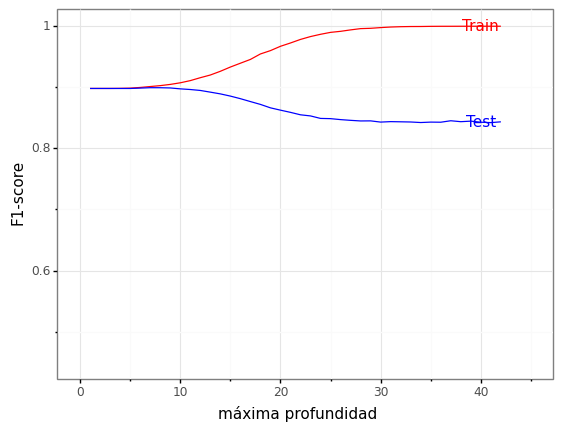

<ggplot: (8736044809989)>

In [34]:
#Graficando los errores
maxDepthTemp=max(resultados.maxDepth)
print(resultados.columns)
print(maxDepthTemp)
(ggplot(resultados)+aes(x="maxDepth")+theme_bw()
 +geom_line(aes(y="meanTrain"),color="red")
 +annotate("text",x=maxDepthTemp-2,y=resultados.iloc[int(maxDepthTemp-1),0],label="Train",color="red")
 +geom_line(aes(y="meanTest"),color="blue")
 +annotate("text",x=maxDepthTemp-2,y=resultados.iloc[int(maxDepthTemp-1),2],label="Test",color="blue")
 +labs(y="F1-score",x="máxima profundidad")
 +xlim(0,45)
 +ylim(0.45,1)
)

## Evalúa tu modelo. ¿Qué performance tiene? ¿Qué métricas usaste para evaluar esa performance y por qué? ¿Por qué elegiste ese algoritmo en particular? ¿Qué variables son las que más influyen en la predicción? ¿Cómo podrías mejorar la performance?


el gráfico es posible concluir que a medida que el árbol se profundiza, el test de entrenamiento decaen y alcanzan una estabilidad a partir de la profundidad 25.

Para determinar específicamente el número de profundidad se recurre a la tabla previamente creada y se comparan los valores de la matriz de confusión. En este caso se opta por el nivel 13 de profundidad ya que presenta mayor diferenciación en su F1-Score respecto al nivel previo. 

El último paso es generar un modelo de Árbol de Decisión con profundidad 6 separando los datos en 70% para entrenamiento y 30% para test.

Valores: 
F1-test:  0.8892460384593696
Recall:  0.9470870870870871
Precision:  0.838063350340136
Accuracy:  0.8080344052389796


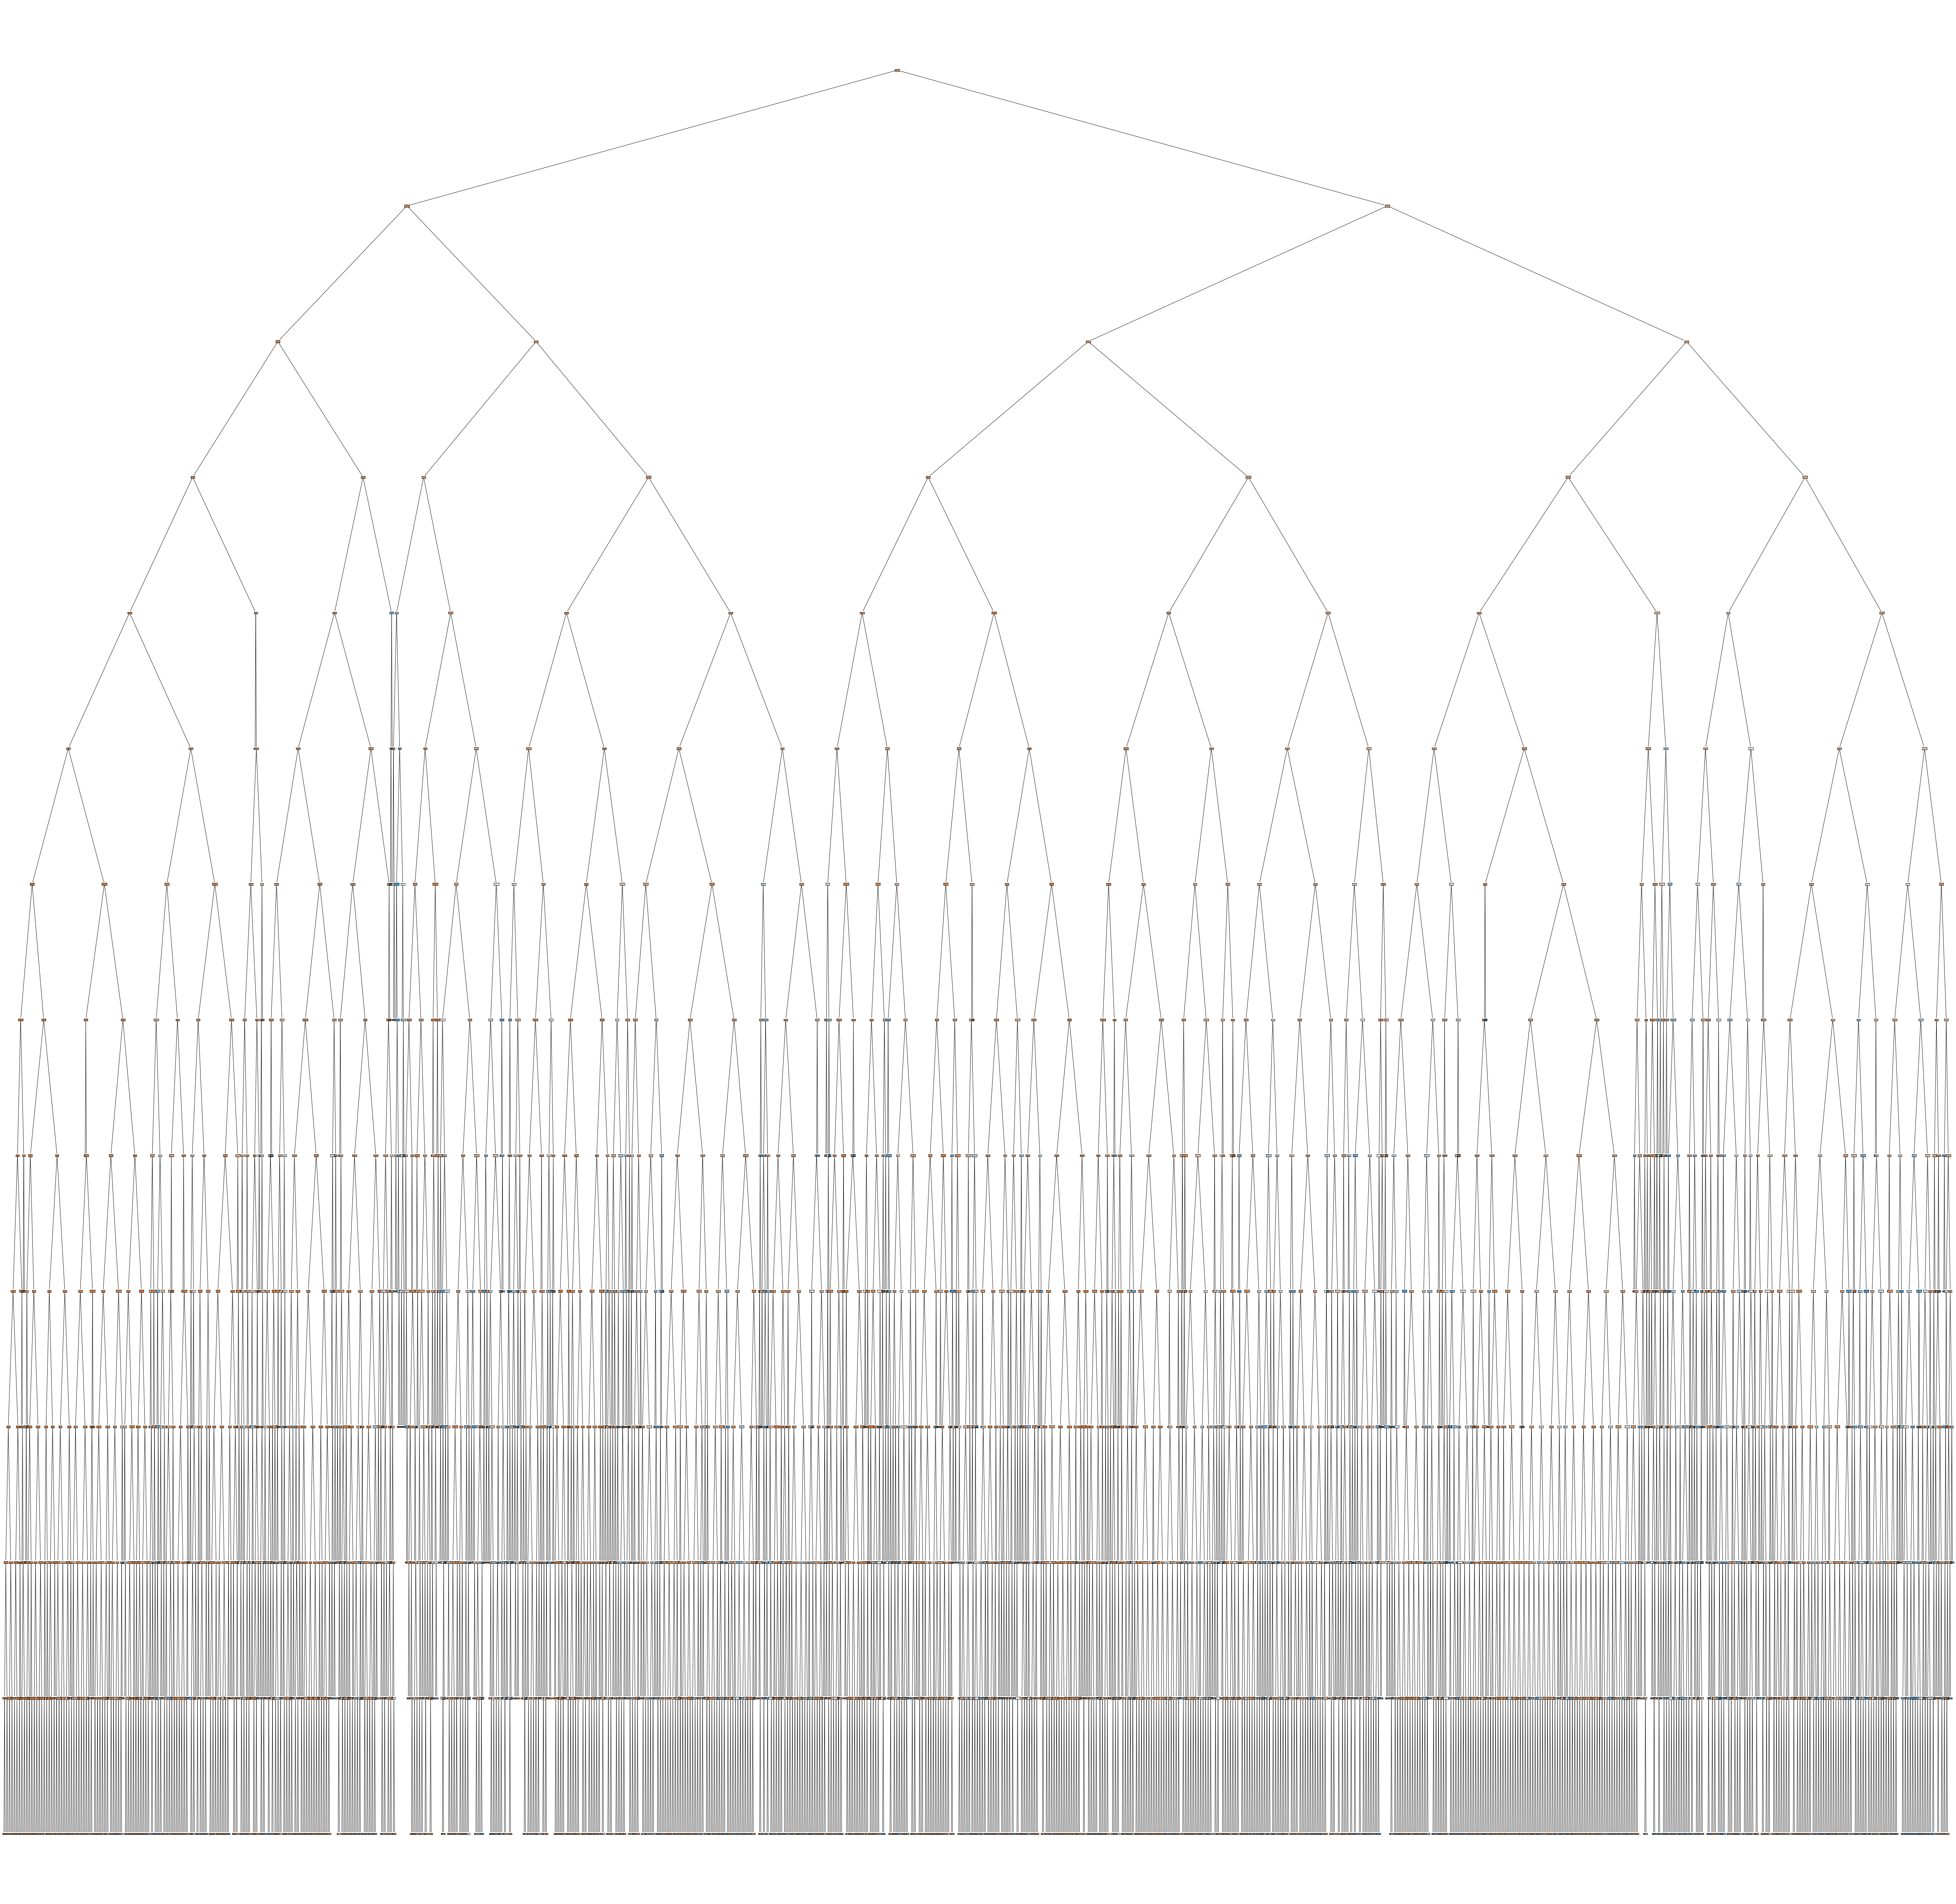

[0.08239302 0.08798688 0.14022202 0.00688261 0.27196694 0.1589023
 0.00741733 0.08622649 0.03052301 0.05860796 0.06082451 0.00804694]


In [36]:
y = datos['atraso_15']
X = datos
X = X.drop(['atraso_15'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,random_state=0)

#Entrene el modelo con el valor de max_depth aprendido sobre todos los datos
finalModel = DecisionTreeClassifier(max_depth=13)
finalModel = finalModel.fit(X_train,y_train)

prediccionFija=finalModel.predict(X_test)

print("Valores: ")
print("F1-test: ",f1_score(y_test,prediccionFija,pos_label=False))
print("Recall: ",recall_score(y_test,prediccionFija,pos_label=False))
print("Precision: ",precision_score(y_test,prediccionFija,pos_label=False))
print("Accuracy: ",accuracy_score(y_test,prediccionFija))

#Muestre el árbol aprendido
plt.figure(figsize=(100,100)) #definiendo el tamaño de la figura
plot_tree(finalModel,filled=True,feature_names=X.columns)
plt.show() #mostrando el árbol

#¿Qué puede deducir del árbol aprendido? ¿Cuáles son las variables más importantes?
print(finalModel.feature_importances_)

Con esto se logra un resultado sobre la muestra de test de F1-Score 0.88 y un Accuracy de  0.80. Las variables que explican mayoritariamente el modelo son el día de semana, la fecha y la hora.

Finalmente, el modelo no cumple los requisitos para ser considerado un buen modelo, ya que su efectividad no es muy alta y la matriz de confusión muestra que, practimente, no está aplicando valores negativos.